In [212]:
import cycler
import matplotlib.pyplot as plt
import numpy as np


In [207]:
import cycler

In [188]:
K = np.arange(1, 50)
inv = 1. / K
zeroshot_pw = -inv*np.log(inv)-(1-inv)*np.log(1-inv)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,'Task Info for Random-DOI, D->+oo')

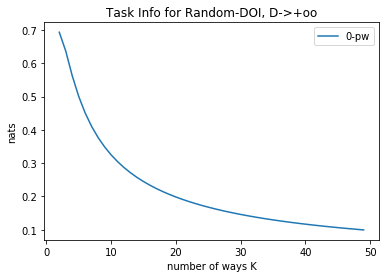

In [189]:
plt.plot(K, zeroshot_pw, label='0-pw')
#plt.semilogx(K, inv, label='0-pw')
plt.legend()
plt.xlabel('number of ways K')
plt.ylabel('nats')
plt.title('Task Info for Random-DOI, D->+oo')

In [190]:
def binary_entropy(p):
    mask = (p<=0)|(p>=1)
    ent = -p*np.log(p) - (1-p)*np.log(1-p)
    ent[mask] = 0
    return ent / np.log(2)

def stats(x):
    assert len(x.shape)==1
    return np.mean(x), np.std(x) / np.sqrt(len(x))

n_samples = 10000
K = 5
D = 10
bernoullis = np.random.uniform(size=(D, n_samples)) < 1. / K
p_z_xx = 1. / D * np.sum(bernoullis, axis=0)

stats(binary_entropy(p_z_xx))

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


(0.6392655973560959, 0.002815684205672317)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


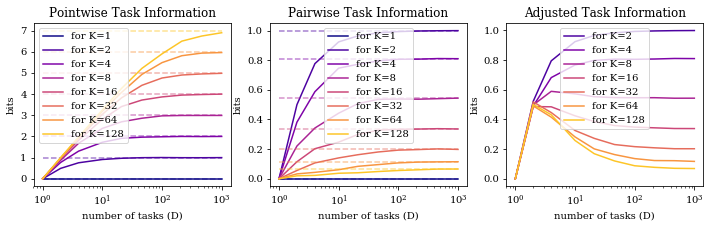

In [333]:
Ks = (1, 2, 4, 8, 16, 32, 64, 128)
Ds = map(int, np.logspace(0, 3, 10))
n_samples = 1000

n = len(Ks) + 1
color = plt.cm.plasma(np.linspace(0, 1,n))
matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
plt.rc('font', family='serif')


plt.figure(figsize=(12,3))
ax = plt.subplot(131)
# unary predictions
for K in Ks:
    unary_labelnoise = []
    for D in Ds:
        bernoullis = np.random.uniform(size=(D-1, n_samples)) < 1. / K
        p_y_x = 1. / D * (1 + np.sum(bernoullis, axis=0))
        mean, std = stats(-np.log(p_y_x) / np.log(2))
        unary_labelnoise.append(mean)

    color = next(ax._get_lines.prop_cycler)['color']
    plt.semilogx(Ds, unary_labelnoise, label='for K={}'.format(K), color=color)
    # plot upper bound
    U = np.log(K) / np.log(2)
    upper = np.ones_like(Ds) * U
    plt.semilogx(Ds, upper, linestyle='--', color=color, alpha=0.5)
    
plt.legend()
plt.xlabel('number of tasks (D)')
plt.ylabel('bits')
plt.title('Pointwise Task Information')
                          
ax = plt.subplot(132)  
# pairwise
for K in Ks:
    pw_labelnoise = []
    for D in Ds:
        bernoullis = np.random.uniform(size=(D, n_samples)) < 1. / K

        # pairwise
        p_z_xx = 1. / D * np.sum(bernoullis, axis=0)
        mean, std = stats(binary_entropy(p_z_xx))
        
        pw_labelnoise.append(mean)
                          
    color = next(ax._get_lines.prop_cycler)['color']
    plt.semilogx(Ds, pw_labelnoise, label='for K={}'.format(K), color=color)
    # plot upper bound
    U = binary_entropy(np.asarray([1./K]))[0]
    upper = np.ones_like(Ds) * U
    plt.semilogx(Ds, upper, linestyle='--', color=color, alpha=0.5)
    
plt.legend()
plt.xlabel('number of tasks (D)')
plt.ylabel('bits')
plt.title('Pairwise Task Information')

ax = plt.subplot(133)  
# balanced-pairwise
for K in Ks:
    adj_labelnoise = []
    for D in Ds:
        if False:  # not sure this is correct
            bernoullis = np.random.uniform(size=(D, n_samples)) < 1. / K

            # pairwise
            p_z_xx = 1. / D * np.sum(bernoullis, axis=0)
            q_z_xx = (K-1)*p_z_xx / ((K-1)*p_z_xx + 1 - p_z_xx)
            mean, std = stats(binary_entropy(q_z_xx))
        else:  # alternative : not sure this is correct either
            b_1over2 = np.random.uniform(size=(1, n_samples)) < 1. / 2
            b_1overk = np.random.uniform(size=(D-1, n_samples)) < 1. / K
            
            # pairwise
            q_z_xx = 1. / D * (np.sum(b_1over2, axis=0) + np.sum(b_1overk, axis=0))
            mean, std = stats(binary_entropy(q_z_xx))            
        
        
        adj_labelnoise.append(mean)
                          
    color = next(ax._get_lines.prop_cycler)['color']
    if K!=1:
        plt.semilogx(Ds, adj_labelnoise, label='for K={}'.format(K), color=color)
plt.legend()
plt.xlabel('number of tasks (D)')
plt.ylabel('bits')
plt.title('Adjusted Task Information')


plt.savefig('randomdoi_vs_kd.pdf', bbox_inches='tight')

# Few-shot Information (Support Set)

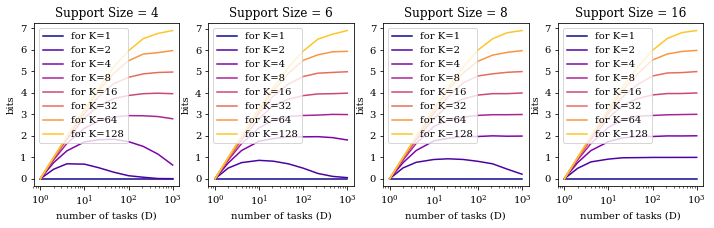

In [332]:
# Pointwise Few-shot information

plt.figure(figsize=(12,3))

support_sizes = [4, 6, 8, 16]
for i, n in enumerate(support_sizes):

    ax = plt.subplot(1, len(support_sizes), i+1)  
    # pairwise
    for K in Ks:
        unary_fewshot_info = []
        for D in Ds:

            bernoullis = np.random.uniform(size=(D-1, n_samples)) < 1. / K
            p_y_x = 1. / D * (1 + np.sum(bernoullis, axis=0))
            h_y_x, std = stats(-np.log(p_y_x) / np.log(2))
            unary_labelnoise.append(mean)

            
            w = (np.random.uniform(size=(D, n_samples)) < (1. / K)**n).astype(float)
            u = (np.random.uniform(size=(D, n_samples)) < 1. / K).astype(float)
            # assume dimension of interest is last one
            w[-1] = 1
            u[-1] = 1
            p_y_xD = (w*u).sum(0) / w.sum(0)
            h_y_xD, std = stats(-np.log(p_y_xD) / np.log(2))

            info = h_y_x - h_y_xD

            unary_fewshot_info.append(info)

        color = next(ax._get_lines.prop_cycler)['color']
        plt.semilogx(Ds, unary_fewshot_info, label='for K={}'.format(K), color=color)
        # plot upper bound
        #U = binary_entropy(np.asarray([1./K]))[0]
        #upper = np.ones_like(Ds) * U
        #plt.semilogx(Ds, upper, linestyle='--', color=color, alpha=0.5)

    plt.legend()
    plt.xlabel('number of tasks (D)')
    plt.ylabel('bits')
    plt.title('Support Size = {}'.format(n))


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


Why for small support sets does the task info go to 0 ?


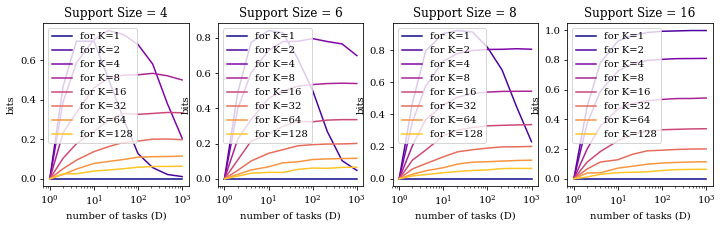

In [328]:
# Pairwise Few-shot information

plt.figure(figsize=(12,3))

support_sizes = [4, 6, 8, 16]
for i, n in enumerate(support_sizes):

    ax = plt.subplot(1, len(support_sizes), i+1)  
    # pairwise
    for K in Ks:
        pw_fewshot_info = []
        for D in Ds:

            bernoullis = np.random.uniform(size=(D, n_samples)) < 1. / K
            # pairwise
            p_z_xx = 1. / D * np.sum(bernoullis, axis=0)
            h_z_xx, std = stats(binary_entropy(p_z_xx))

            w = (np.random.uniform(size=(D, n_samples)) < (1. / K)**n).astype(float)
            u = (np.random.uniform(size=(D, n_samples)) < 1. / K).astype(float)
            # assume dimension of interest is last one
            w[-1] = 1
            p_z_xxD = (w*u).sum(0) / w.sum(0)
            h_z_xxD, std = stats(binary_entropy(p_z_xxD))

            info = h_z_xx - h_z_xxD

            pw_fewshot_info.append(info)

        color = next(ax._get_lines.prop_cycler)['color']
        plt.semilogx(Ds, pw_fewshot_info, label='for K={}'.format(K), color=color)
        # plot upper bound
        #U = binary_entropy(np.asarray([1./K]))[0]
        #upper = np.ones_like(Ds) * U
        #plt.semilogx(Ds, upper, linestyle='--', color=color, alpha=0.5)

    plt.legend()
    plt.xlabel('number of tasks (D)')
    plt.ylabel('bits')
    plt.title('Support Size = {}'.format(n))
    
print('Why for small support sets does the task info go to 0 ?'
     'Because when the number of tasks is high, but the support set does not give enough information'
     'then the task information is still low')

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


Why for small support sets does the task info go to 0 ?Because when the number of tasks is high, but the support set does not give enough informationthen the task information is still low


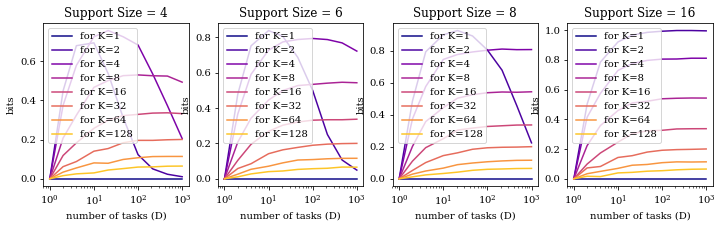

In [329]:
plt.figure(figsize=(12,3))

support_sizes = [4, 6, 8, 16]
for i, n in enumerate(support_sizes):

    ax = plt.subplot(1, len(support_sizes), i+1)  
    # pairwise
    for K in Ks:
        pw_fewshot_info = []
        for D in Ds:

            bernoullis = np.random.uniform(size=(D, n_samples)) < 1. / K

            # pairwise
            p_z_xx = 1. / D * np.sum(bernoullis, axis=0)
            q_z_xx = (K-1)*p_z_xx / ((K-1)*p_z_xx + 1 - p_z_xx)
            h_z_xx, std = stats(binary_entropy(q_z_xx))

            w = (np.random.uniform(size=(D, n_samples)) < (1. / K)**n).astype(float)
            u = (np.random.uniform(size=(D, n_samples)) < 1. / K).astype(float)
            # assume dimension of interest is last one
            w[-1] = 1
            p_z_xxD = (w*u).sum(0) / w.sum(0)
            h_z_xxD, std = stats(binary_entropy(p_z_xxD))

            info = h_z_xx - h_z_xxD

            pw_fewshot_info.append(info)

        color = next(ax._get_lines.prop_cycler)['color']
        plt.semilogx(Ds, pw_fewshot_info, label='for K={}'.format(K), color=color)
        # plot upper bound
        #U = binary_entropy(np.asarray([1./K]))[0]
        #upper = np.ones_like(Ds) * U
        #plt.semilogx(Ds, upper, linestyle='--', color=color, alpha=0.5)

    plt.legend()
    plt.xlabel('number of tasks (D)')
    plt.ylabel('bits')
    plt.title('Support Size = {}'.format(n))
    


In [290]:
w.sum(0)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1,

In [246]:
X_train, Y_train, __, __, __ = get_support(n, D, K, 0)

In [250]:
X_train[0].tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0